In [ ]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
!mkdir .kaggle

In [ ]:
import json
token = {"username":"mahtab99","key":"f7c082e582d76ad23f429ca74c08bf3d"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge -p /content

 81% 63.0M/77.3M [00:00<00:00, 95.6MB/s]
100% 77.3M/77.3M [00:00<00:00, 132MB/s] 
 88% 81.0M/92.0M [00:00<00:00, 106MB/s] 
100% 92.0M/92.0M [00:00<00:00, 187MB/s]
 89% 86.0M/96.6M [00:00<00:00, 143MB/s]
100% 96.6M/96.6M [00:00<00:00, 165MB/s]
 88% 17.0M/19.3M [00:00<00:00, 75.5MB/s]
100% 19.3M/19.3M [00:00<00:00, 76.7MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.21MB/s]


In [ ]:
!unzip \*.zip

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  icml_face_data.csv.zip
  inflating: icml_face_data.csv      

3 archives were successfully processed.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)
!pip3 install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds
import tarfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout ,Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
data = pd.read_csv('icml_face_data.csv')

In [ ]:
data_set.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data_set.shape

(28709, 2)

In [ ]:
import collections
ax = np.array(data_set.emotion)
collections.Counter(ax)

Counter({0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965})

# Preprocessing


In [ ]:
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
len (data_set["pixels"][0])

8287

In [ ]:
def data_prep(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        if i==11:
          original_image = image
          img = image 
        image = cv2.normalize(image.astype(np.uint8),  None , 0, 255, cv2.NORM_MINMAX)
        image = cv2.equalizeHist(image.astype(np.uint8))
        image_array[i] = image
        if i==11:
          norm_img = image
          image = median_filter(np.float32(img), 5 )
          noise_removed_image = image
          img =  img.astype(np.uint8)
          edge_image = cv2.Canny(img,150,200)
    display(original_image,norm_img,"original","normalize & equalize") 
    display(original_image,noise_removed_image,"original","removed noise")    
    display(original_image,edge_image,"original","Edges")    
    return image_array, image_label

In [ ]:
from tqdm import tqdm

def median_filter(img, filter_size):
    temp = []
    index = filter_size // 2
    new_img = []
    new_img = np.zeros((img.shape[0], img.shape[1]), np.int32)
    for i in (range(img.shape[0])):
        for j in (range(img.shape[1])):
            if img[i][j]== 0 or img[i][j] == 255 :
              coun=0
              for z in range(filter_size):
                if -1<i + z - index < img.shape[0]:   
                    for k in range(filter_size):
                      if(-1<j + k - index<img.shape[1]):
                          temp.append(img[i + z - index][j + k - index])
              temp.sort()
              new_img[i][j] = temp[int(len(temp) / 2)]
              temp = []
            else:
              new_img[i][j]= img[i][j]
    plt.imshow(new_img, cmap=plt.get_cmap('gray'))
    plt.plot()
    return new_img

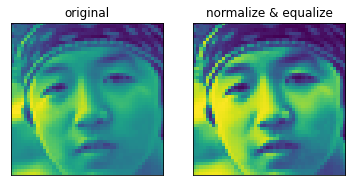

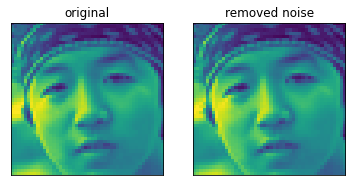

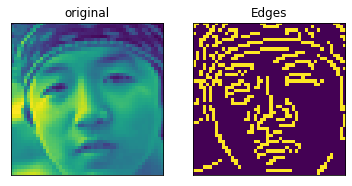

In [ ]:
X , Y = data_prep(data_set)

In [ ]:
def split_data(X,Y):  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=41)
  X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
  X_train = X_train.astype('float32')/255
  X_valid = X_valid.reshape((X_valid.shape[0], 48, 48, 1))
  X_valid = X_valid.astype('float32')/255
  X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
  X_test = X_test.astype('float32')/255
  y_train = keras.utils.to_categorical(y_train)
  y_valid = keras.utils.to_categorical(y_valid)
  y_test = keras.utils.to_categorical(y_test)
  print ("X_train shape: " + str(X_train.shape))
  print ("Y_train shape: " + str(y_train.shape))
  print ("X_test shape: " + str(X_test.shape))
  print ("Y_test shape: " + str(y_test.shape))
  print ("X_valid shape: " + str(X_valid.shape))
  print ("Y_valid shape: " + str(y_valid.shape))
  return X_train, X_test, y_train, y_test ,X_valid, y_valid

In [ ]:
X_train, X_test, y_train, y_test, X_valid, y_valid  = split_data(X,Y)

X_train shape: (20741, 48, 48, 1)
Y_train shape: (20741, 7)
X_test shape: (4307, 48, 48, 1)
Y_test shape: (4307, 7)
X_valid shape: (3661, 48, 48, 1)
Y_valid shape: (3661, 7)


In [ ]:
import matplotlib
from matplotlib import pyplot 
def display_preprocessing(X_train):
      for i in range(10000, 10009):
          pyplot.subplot(330 + 1 + i-10000)
          pyplot.imshow(X_train[i].reshape(48,48) ,cmap=plt.get_cmap('gray'))
      # show the plot
      pyplot.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        # rescale = 1./255,
        # zoom_range=[0.5,1.0],
        brightness_range=[0.2,1.0],
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        # zca_whitening=True,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range 
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)
datagen.fit(X_valid)

#Models

In [ ]:
import pandas as pd
def show_history(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return

## **paper model**

In [ ]:
from keras.utils.vis_utils import plot_model

def generate_model(lr=0.001):
    
    """training model"""
    
    with tf.device('/gpu:0'):  
        
        model = keras.models.Sequential()
        
        model.add(keras.layers.Conv2D(64,(3,3), input_shape=(48,48, 1), padding="same"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.Dropout(0.20))
        
        model.add(keras.layers.Conv2D(128,(5,5), padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.Dropout(0.20))

        model.add(keras.layers.Conv2D(512,(3,3), padding="same"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.Dropout(0.20))
        
        model.add(keras.layers.Conv2D(512,(3,3)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.Dropout(0.25))
        
        model.add(keras.layers.Conv2D(256,(3,3), activation='relu',padding='same'))
        model.add(keras.layers.Conv2D(128,(3,3), padding='same', activation='relu'))
        model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.Dropout(0.25))
        
        
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(256))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Dropout(0.5))
        
        model.add(keras.layers.Dense(512, activation='relu'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Dropout(0.5))
        
        model.add(keras.layers.Dense(7,activation='softmax'))

        opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        loss = keras.losses.categorical_crossentropy
        model.compile(loss = keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
        model.summary()
        plot_model(model, to_file='fer_model.png', show_shapes=True, show_layer_names=True)
        return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

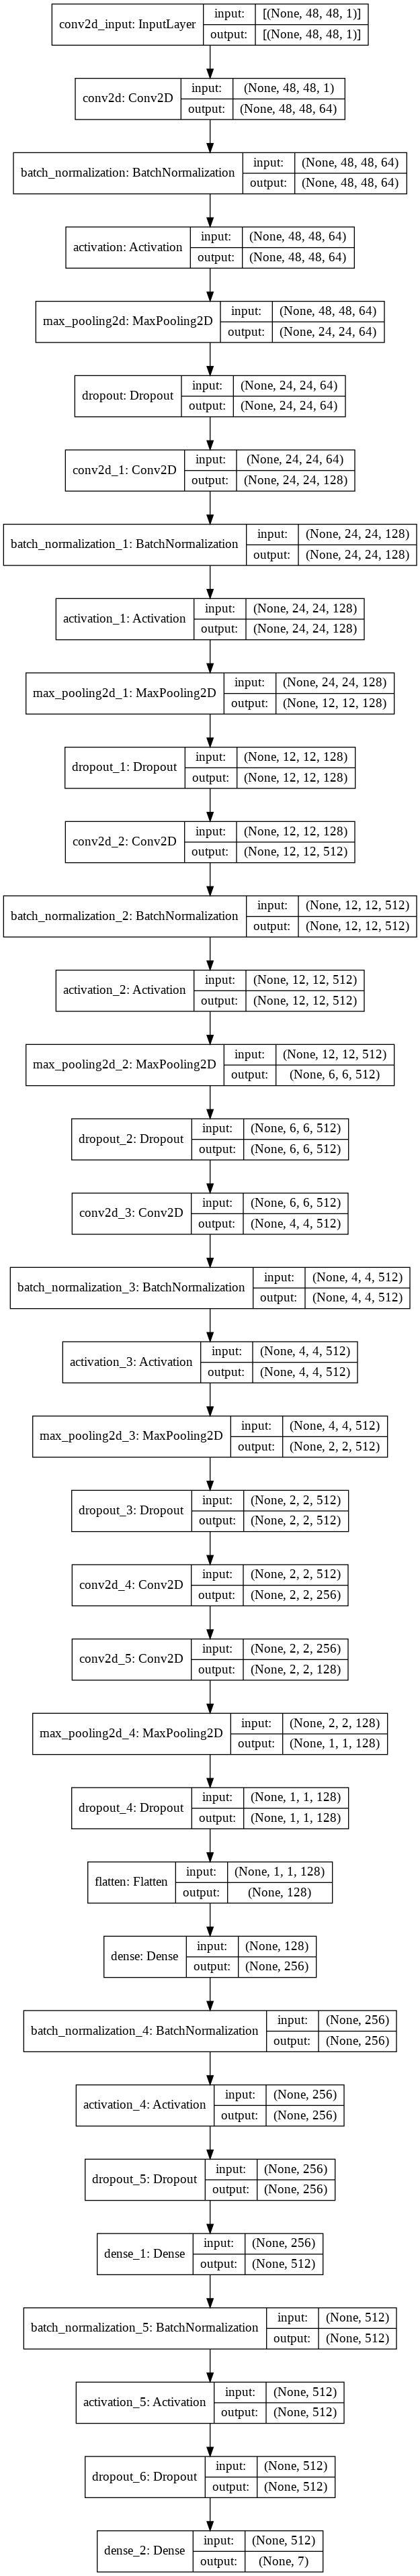

In [ ]:
model = generate_model(0.01)
tf.keras.utils.plot_model(
    model, to_file='paper_model.png', show_shapes=True)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CVision' + '/paper_model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
from tensorflow.keras.callbacks import ReduceLROnPlateau
learn_rate_fuc = ReduceLROnPlateau(monitor='val_accuracy',
                                   patience=3,
                                   verbose=1,
                                   factor=0.5,
                                   min_lr=0.000005)
with tf.device("/gpu:0"):

  history = model.fit(
      X_train,y_train,
      validation_data = (X_valid,y_valid), 
      verbose=1,
      batch_size=128,
      callbacks=[checkpoint_cb, early_stopping_cb,learn_rate_fuc],
      epochs = 60)
      

Epoch 1/60
163/163 [==============================] - 13s 32ms/step - loss: 2.5034 - accuracy: 0.1770 - val_loss: 1.8818 - val_accuracy: 0.1762
Epoch 2/60
163/163 [==============================] - 5s 28ms/step - loss: 2.0208 - accuracy: 0.2083 - val_loss: 2.2244 - val_accuracy: 0.1076
Epoch 3/60
163/163 [==============================] - 5s 28ms/step - loss: 1.7006 - accuracy: 0.3135 - val_loss: 2.1402 - val_accuracy: 0.1095
Epoch 4/60
163/163 [==============================] - 5s 28ms/step - loss: 1.5623 - accuracy: 0.3803 - val_loss: 1.6622 - val_accuracy: 0.3171
Epoch 5/60
163/163 [==============================] - 5s 28ms/step - loss: 1.5165 - accuracy: 0.4008 - val_loss: 1.3865 - val_accuracy: 0.4523
Epoch 6/60
163/163 [==============================] - 5s 28ms/step - loss: 1.3707 - accuracy: 0.4656 - val_loss: 1.3665 - val_accuracy: 0.4930
Epoch 7/60
163/163 [==============================] - 5s 28ms/step - loss: 1.3995 - accuracy: 0.4670 - val_loss: 1.3147 - val_accuracy: 0.499

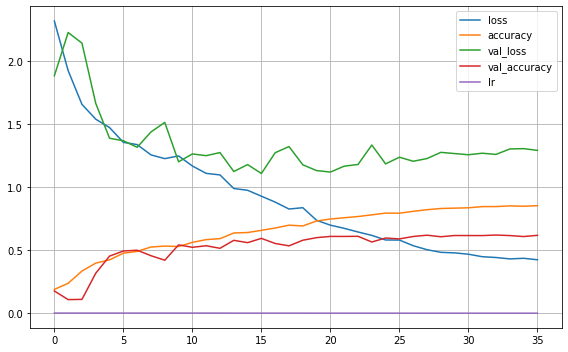

In [ ]:
show_history(history)

In [ ]:
def test_prediction(model , X_test,y_test):
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print('test caccuracy:', test_acc)
  pred_test_labels = model.predict(X_test)
  for i in range(100 ,110,2):
    plot_image(X_test, y_test, pred_test_labels, i)
  return pred_test_labels


In [ ]:
def plot_image(X_test, y_test, pred_test_labels, image_number):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=False)
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    bar_label = emotions.values()

    axs[0].imshow(X_test[image_number].reshape(48,48),cmap=plt.get_cmap('gray'))
    title=0
    for i in range (0,7):
      if y_test[image_number][i] == 1 :
        title=i
    axs[0].set_title(emotions[title])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

135/135 [==============================] - 1s 6ms/step - loss: 1.1260 - accuracy: 0.5851
test caccuracy: 0.5850940346717834


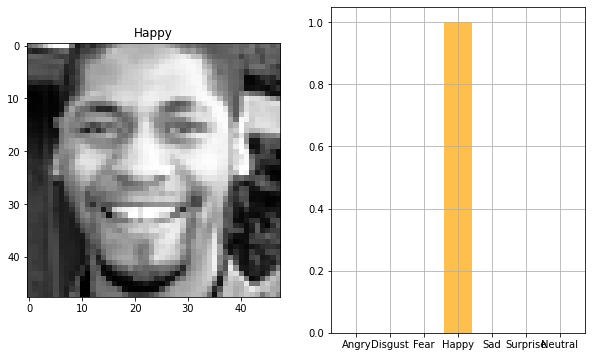

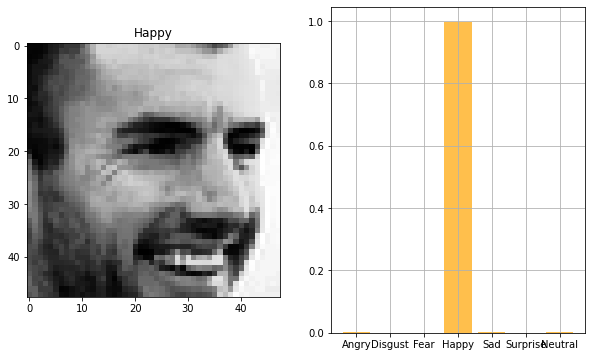

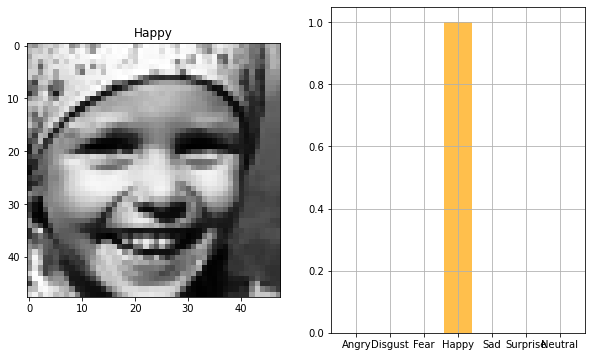

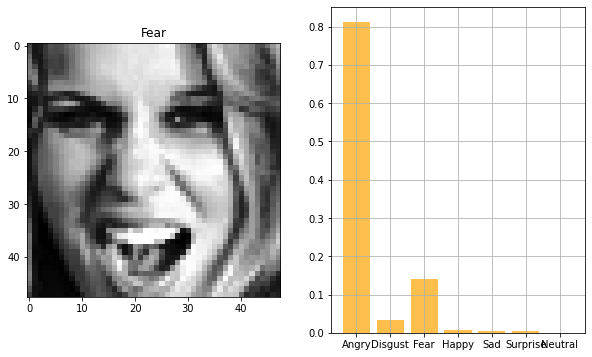

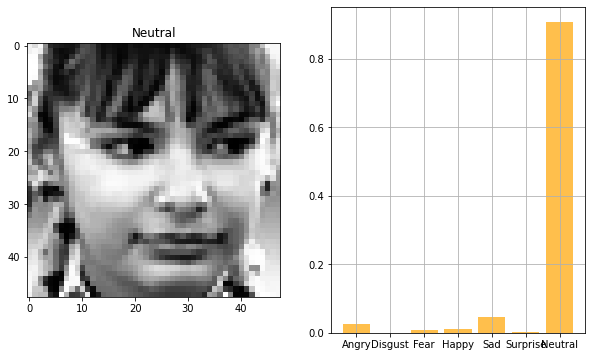

In [ ]:
pred_test_labels = test_prediction(model , X_test,y_test)

[[302   0  17  44  87   4 103]
 [ 44   0   2   1   8   1   5]
 [126   0 106  44 184  58 111]
 [ 39   0   9 927  48  18  51]
 [ 98   0  20  51 387  10 184]
 [ 22   0  32  34  12 337  38]
 [ 54   0  14  84 121   9 461]]


Text(0.5, -11.327610883458874, 'Predicted label')

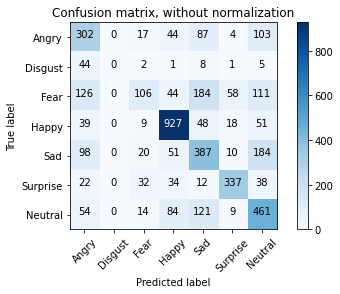

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import plot_confusion_matrix
cmap=plt.cm.Blues
cm = confusion_matrix( np.argmax(y_test, axis=1), np.argmax(pred_test_labels, axis=1))
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## mini VGG

In [ ]:
input_size=(48, 48, 1)

In [ ]:
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras import regularizers
def model_vgg():
        model = Sequential(name="MiniVGG13")
        model.add(Conv2D(64, (3, 3), input_shape=input_size, padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))


        model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))

       
        model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))


        model.add(Conv2D(512, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(Conv2D(512, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(Conv2D(512, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))

        model.add(Flatten())
        model.add(Dense(64, kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.35))

 
        model.add(Dense(64, kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.35))

        
        model.add(Dense(7, kernel_regularizer=regularizers.l2(0.0002)))
        model.add(Activation("softmax"))

        opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        loss = keras.losses.categorical_crossentropy
        model.compile(loss = keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
        model.summary()
        plot_model(model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)
        return model

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CVision' + '/vgg_model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [ ]:
model = model_vgg()

Model: "MiniVGG13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        192       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 64)        0 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learn_rate_fuc = ReduceLROnPlateau(monitor='val_accuracy',
                                   patience=3,
                                   verbose=1,
                                   factor=0.5,
                                   min_lr=0.000005)
history_vgg_model = model.fit(
    X_train,y_train,
    validation_data = (X_valid,y_valid), 
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb,learn_rate_fuc],
    epochs = 100)

Epoch 1/100
649/649 [==============================] - 17s 23ms/step - loss: 2.8428 - accuracy: 0.1731 - val_loss: 2.2226 - val_accuracy: 0.1532
Epoch 2/100
649/649 [==============================] - 14s 22ms/step - loss: 2.1820 - accuracy: 0.2242 - val_loss: 2.0289 - val_accuracy: 0.1928
Epoch 3/100
649/649 [==============================] - 14s 22ms/step - loss: 1.9766 - accuracy: 0.2618 - val_loss: 1.8722 - val_accuracy: 0.2857
Epoch 4/100
649/649 [==============================] - 14s 22ms/step - loss: 1.8446 - accuracy: 0.3039 - val_loss: 1.8181 - val_accuracy: 0.2726
Epoch 5/100
649/649 [==============================] - 15s 22ms/step - loss: 1.7505 - accuracy: 0.3344 - val_loss: 1.9451 - val_accuracy: 0.2232
Epoch 6/100
649/649 [==============================] - 14s 22ms/step - loss: 1.6743 - accuracy: 0.3740 - val_loss: 2.0218 - val_accuracy: 0.2092

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
649/649 [============================

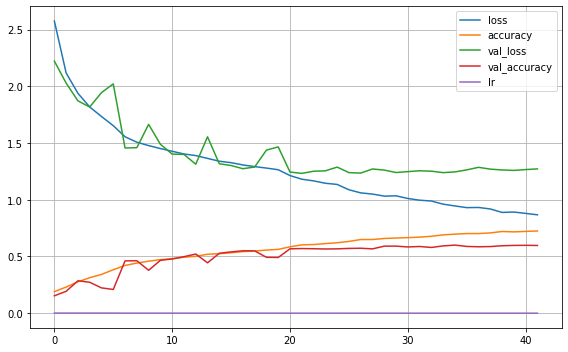

In [ ]:
show_history(history_vgg_model)

135/135 [==============================] - 1s 8ms/step - loss: 1.2364 - accuracy: 0.5739
test caccuracy: 0.57394939661026


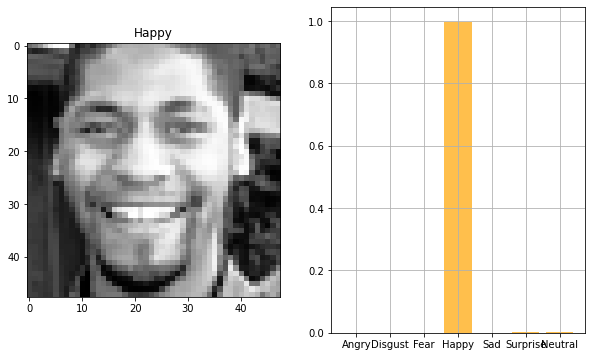

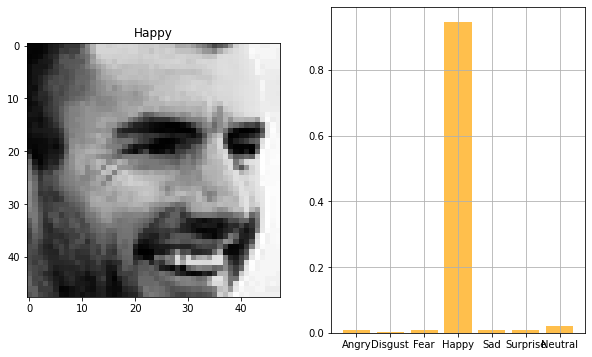

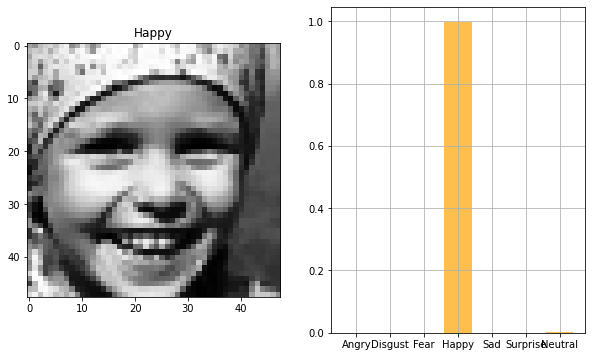

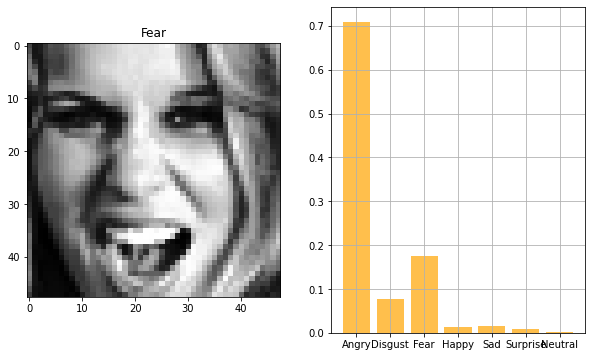

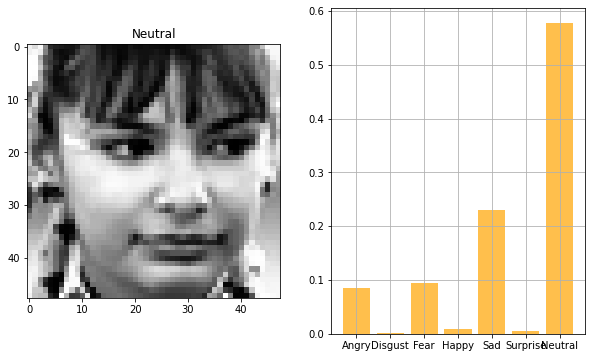

In [ ]:
pred_test_labels =test_prediction(model , X_test,y_test)

[[204   0  45  31 178  13  86]
 [ 38   0   4   2  12   2   3]
 [ 69   0 115  25 205  95 120]
 [ 22   0  14 904  45  35  72]
 [ 51   0  32  34 395  13 225]
 [  6   0  39  23  17 362  28]
 [  1   0  24  51 162  13 492]]


Text(0.5, -11.327610883458874, 'Predicted label')

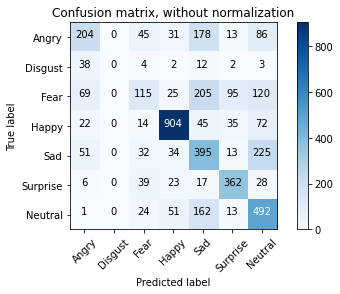

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import plot_confusion_matrix
cmap=plt.cm.Blues
cm = confusion_matrix( np.argmax(y_test, axis=1), np.argmax(pred_test_labels, axis=1))
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')